# Fine tune DNN parameters

### Note that you have to execute the first 4 cells and then you can execute each part of this notebook separately

This notebook's aim is to find appropriate parameters and the best loss function for the implemented deep neural network which optimize training speed and provide a coherent, diversified trading strategy. We experiment with the first 7 months of data (6 months for training and 1 month for testing) as this will be the rolling window used in the final strategy.

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload


In [2]:
# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=2000000, low_quantile=0.005, up_quantile=0.995)
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
1841513,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,-0.006535
1841514,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,-0.006535
1841515,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,-0.006535
1841516,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,-0.006535


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
706883     2000-06
889939     2000-07
1056371    2000-08
1248826    2000-09
1415409    2000-10
1598244    2000-11
1771577    2000-12
Name: year_month, dtype: period[M]

## First run: 50 epochs, regularized softmax loss function

In [5]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [6]:
epochs = 30
max_weight = 0.05  # No stock >5% weight
diversification_lambda = 0.01  # Strength of penalty
temperature = 1.0  # Softmax temperature (lower = more diversification)
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)

Starting training with 435 train batches, 41 test batches


Training:   3%|█▏                                | 1/30 [00:14<06:51, 14.18s/it]

Epoch 1/30, Loss: -0.0759, Train Sharpe: 0.0112, Test Sharpe: -0.0101, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  10%|███▍                              | 3/30 [00:41<06:12, 13.81s/it]

Epoch 3/30, Loss: -0.0893, Train Sharpe: 0.0418, Test Sharpe: 0.0294, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  17%|█████▋                            | 5/30 [01:09<05:50, 14.01s/it]

Epoch 5/30, Loss: -0.1115, Train Sharpe: 0.0506, Test Sharpe: 0.0392, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  23%|███████▉                          | 7/30 [01:37<05:18, 13.86s/it]

Epoch 7/30, Loss: -0.1203, Train Sharpe: 0.0574, Test Sharpe: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  30%|██████████▏                       | 9/30 [02:05<04:53, 13.96s/it]

Epoch 9/30, Loss: -0.1249, Train Sharpe: 0.0606, Test Sharpe: 0.0396, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  37%|████████████                     | 11/30 [02:33<04:24, 13.94s/it]

Epoch 11/30, Loss: -0.1283, Train Sharpe: 0.0632, Test Sharpe: 0.0408, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  43%|██████████████▎                  | 13/30 [03:00<03:56, 13.90s/it]

Epoch 13/30, Loss: -0.1314, Train Sharpe: 0.0648, Test Sharpe: 0.0411, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  50%|████████████████▌                | 15/30 [03:29<03:30, 14.01s/it]

Epoch 15/30, Loss: -0.1326, Train Sharpe: 0.0648, Test Sharpe: 0.0403, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  57%|██████████████████▋              | 17/30 [03:57<03:03, 14.09s/it]

Epoch 17/30, Loss: -0.1353, Train Sharpe: 0.0661, Test Sharpe: 0.0398, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  63%|████████████████████▉            | 19/30 [04:25<02:34, 14.04s/it]

Epoch 19/30, Loss: -0.1371, Train Sharpe: 0.0668, Test Sharpe: 0.0419, Avg Weight: 0.0002, Max Weight: 0.0024


Training:  70%|███████████████████████          | 21/30 [04:53<02:05, 14.00s/it]

Epoch 21/30, Loss: -0.1378, Train Sharpe: 0.0678, Test Sharpe: 0.0417, Avg Weight: 0.0002, Max Weight: 0.0024


Training:  77%|█████████████████████████▎       | 23/30 [05:22<01:39, 14.18s/it]

Epoch 23/30, Loss: -0.1401, Train Sharpe: 0.0683, Test Sharpe: 0.0418, Avg Weight: 0.0002, Max Weight: 0.0024


Training:  83%|███████████████████████████▌     | 25/30 [05:50<01:10, 14.12s/it]

Epoch 25/30, Loss: -0.1414, Train Sharpe: 0.0685, Test Sharpe: 0.0415, Avg Weight: 0.0002, Max Weight: 0.0025


Training:  90%|█████████████████████████████▋   | 27/30 [06:18<00:42, 14.10s/it]

Epoch 27/30, Loss: -0.1423, Train Sharpe: 0.0691, Test Sharpe: 0.0419, Avg Weight: 0.0002, Max Weight: 0.0026


Training:  97%|███████████████████████████████▉ | 29/30 [06:46<00:14, 14.00s/it]

Epoch 29/30, Loss: -0.1438, Train Sharpe: 0.0694, Test Sharpe: 0.0426, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|█████████████████████████████████| 30/30 [07:00<00:00, 14.01s/it]

Epoch 30/30, Loss: -0.1440, Train Sharpe: 0.0699, Test Sharpe: 0.0419, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0426


In [7]:
'''
TC_RATE = 0.002 # Fixed transaction costs

test_df['weight'] = weights.values  # Current weights
# Deduct costs every day
test_df['tc_cost'] = np.abs(test_df['weight'].diff().fillna(0.0)) * TC_RATE
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
'''

reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['weight'] = weights.values
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))


test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']

test_df['weight_change'].describe()
#test_df['strategy_return'].describe()

count    166432.000000
mean          0.000324
std           0.000371
min           0.000000
25%           0.000038
50%           0.000168
75%           0.000512
max           0.002437
Name: weight_change, dtype: float64

Weights are nicely spread out. The strategy is successfully diversified unlike the strategy which directly maximizes Sharpe ratio. 

In [8]:
test_df['tc_cost'].describe()

count    1.664320e+05
mean     1.046322e-06
std      1.242342e-06
min      0.000000e+00
25%      1.144096e-07
50%      5.131322e-07
75%      1.614648e-06
max      9.092185e-06
Name: tc_cost, dtype: float64

In [9]:
mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
mean_daily_returns

date
2000-07-03    0.008641
2000-07-05   -0.008365
2000-07-06    0.010349
2000-07-07    0.013418
2000-07-10    0.004808
2000-07-11    0.001678
2000-07-12    0.026373
2000-07-13    0.006467
2000-07-14    0.018311
2000-07-17    0.008821
2000-07-18    0.001777
2000-07-19   -0.013020
2000-07-20    0.010204
2000-07-21   -0.010864
2000-07-24   -0.023698
2000-07-25   -0.005104
2000-07-26   -0.007460
2000-07-27   -0.026046
2000-07-28   -0.036226
2000-07-31    0.021984
Name: strategy_return, dtype: float64

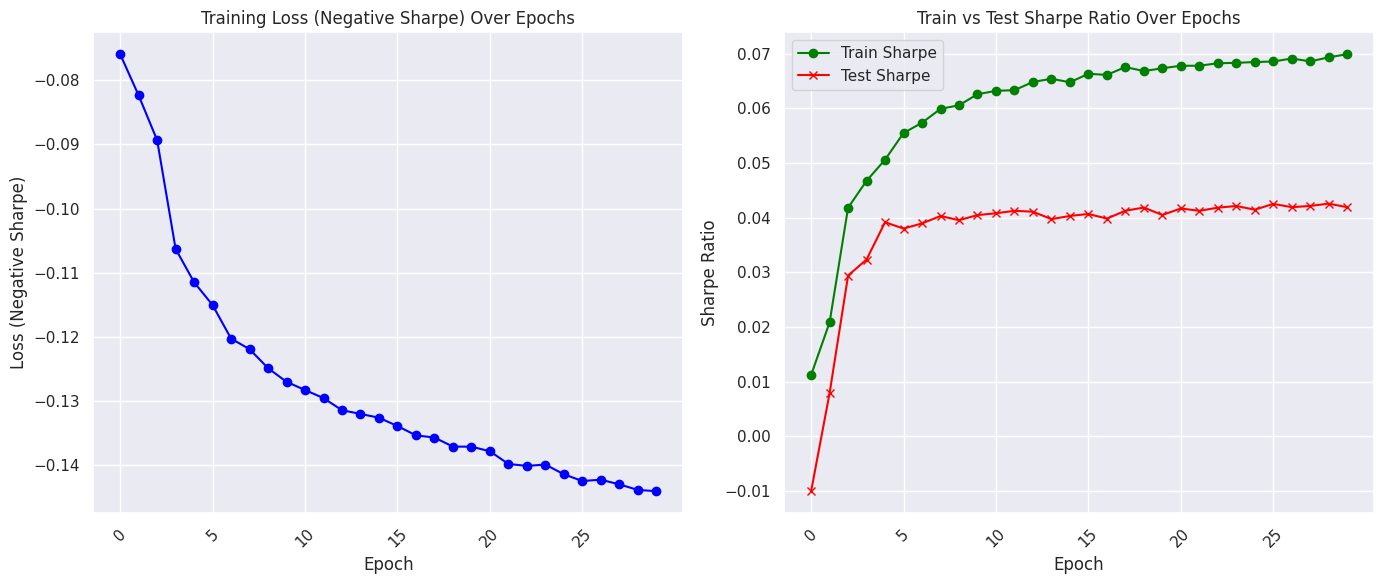

In [10]:
reload(utils) # In case the python module is modified
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

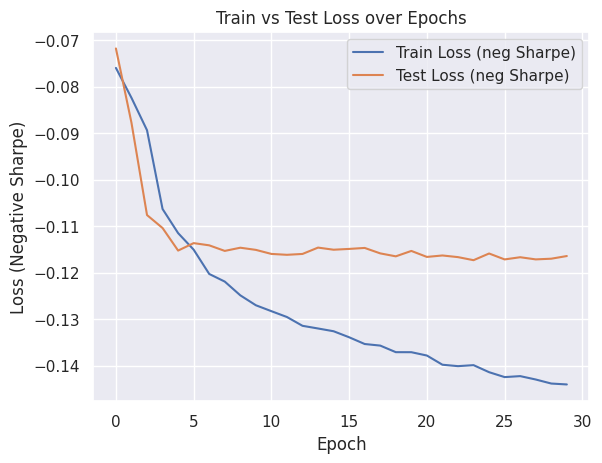

In [11]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

As can be seen by the above plots, the out of sample Sharpe ratio doesn't increase much further after 4-5 epochs. Therefore there is no point training the model on many epochs. 

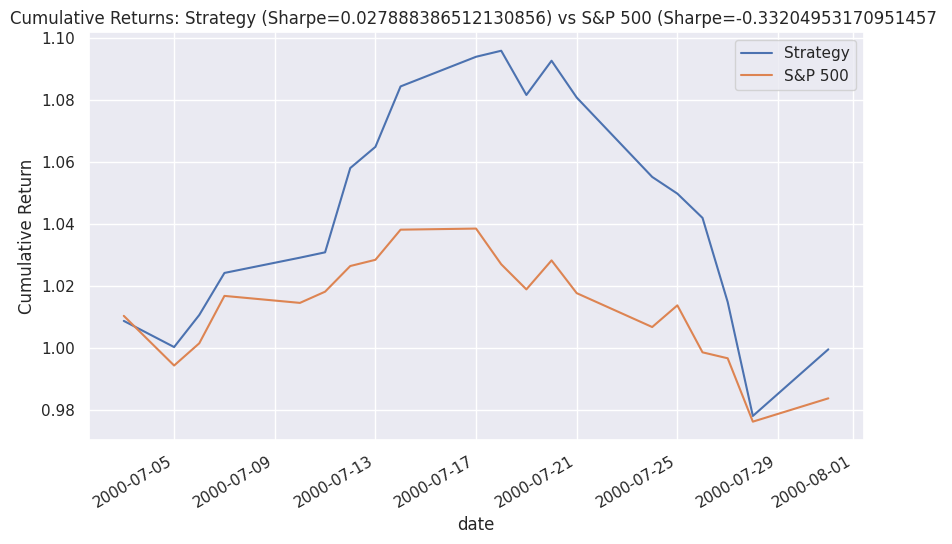

In [12]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

## Second run: negative Sharpe ratio loss 

It seems a high number of epochs isn't necessary for convergence for the regularized softmax function. However, this may not be the case for other loss functions. Actually, it reduces out of sample Sharpe ratio as it overfits the training data. We can train faster using less epochs and a higher learning rate. The above plots suggest 3 epochs is sufficient. However, since this is quite low, we first try with 10 and a faster learning rate of 0.01 instead of 0.001.

In [23]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [24]:
epochs = 5
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, _ = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'neg_sharpe')

Starting training with 435 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:14<00:56, 14.21s/it]

Epoch 1/5, Loss: 0.0049, Train Sharpe: 0.0115, Test Sharpe: 0.0239


Training:  60%|█████████████████████              | 3/5 [00:44<00:29, 14.92s/it]

Epoch 3/5, Loss: -0.0530, Train Sharpe: 0.0484, Test Sharpe: 0.0555


Training: 100%|███████████████████████████████████| 5/5 [01:14<00:00, 14.99s/it]

Epoch 5/5, Loss: -0.0582, Train Sharpe: 0.0530, Test Sharpe: 0.0523
Training completed! Best test Sharpe ratio: 0.0555


In [25]:
reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['raw_predictions'] = raw_predictions.values
def softmax(x):
        e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
        return e_x / e_x.sum()
    
# Apply softmax within each date group
test_df['weight'] = test_df.groupby('date')['raw_predictions'].transform(softmax)
    
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))

test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
test_df['return_no_cost'] = test_df['weight'] * test_df['DlyRet']
#test_df['weight_change'].describe()
#test_df['strategy_return'].describe()

mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
mean_returns_no_cost = test_df.groupby('date')['return_no_cost'].sum()
mean_daily_returns

date
2000-07-03   -0.018767
2000-07-05   -0.331581
2000-07-06   -0.299573
2000-07-07   -0.331386
2000-07-10   -0.641806
2000-07-11   -0.519674
2000-07-12   -0.031083
2000-07-13   -0.149160
2000-07-14   -0.225747
2000-07-17   -0.268451
2000-07-18   -0.646857
2000-07-19   -0.499747
2000-07-20   -0.600897
2000-07-21   -0.182076
2000-07-24   -0.081165
2000-07-25   -0.157967
2000-07-26   -0.117775
2000-07-27   -0.174403
2000-07-28   -0.186832
2000-07-31   -0.125142
Name: strategy_return, dtype: float64

In [26]:
test_df['weight'].describe()

count    1.664320e+05
mean     1.201692e-04
std      7.608007e-03
min      1.678961e-34
25%      1.167954e-18
50%      3.125444e-16
75%      2.400364e-13
max      9.960732e-01
Name: weight, dtype: float64

As we can observe, maximizing the Sharpe ratio directly is a bad idea as it forces the model to invest all of its money in a single stock. There is no diversification and transaction costs kill any profit the strategy may make. 

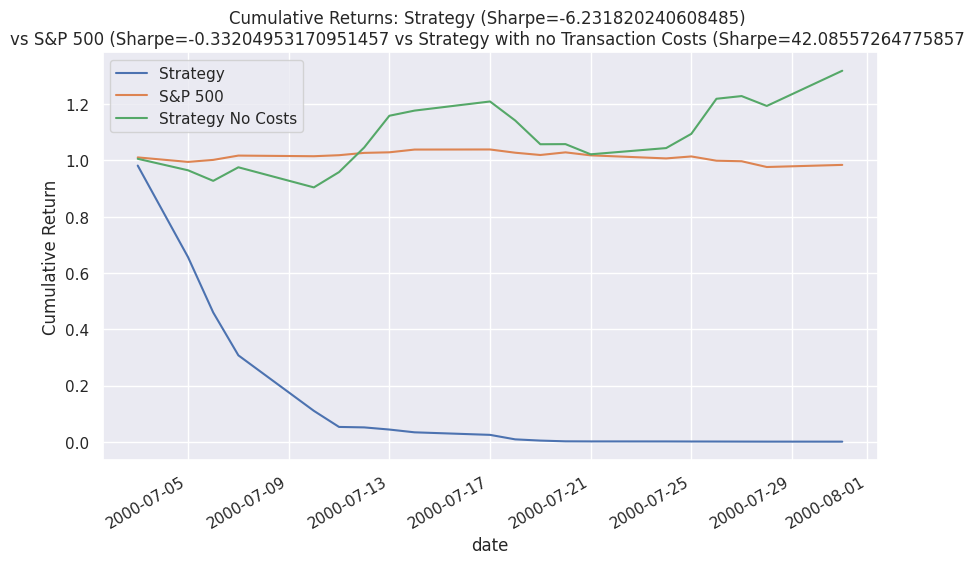

In [28]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
cum_ret_no_cost = (1 + mean_returns_no_cost).cumprod()
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500,
    'Strategy No Costs': cum_ret_no_cost
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())
strat_sharpe_no_tc = np.sqrt(cum_ret_no_cost.shape[0]) * (cum_ret_no_cost.mean() / cum_ret_no_cost.std() + 10e-8)

# Plot
combined.plot(figsize=(10, 6), title=f'''Cumulative Returns: Strategy (Sharpe={strat_sharpe}) 
vs S&P 500 (Sharpe={sp_sharpe} vs Strategy with no Transaction Costs (Sharpe={strat_sharpe_no_tc} ''')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

We can see that the transaction costs, especially the quadratic costs kill the strategy's returns, making it lose all of the money invested after only 2 weeks. 

# Third run: linear rank-based loss 

In [18]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [19]:
epochs = 5
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'lin_rank')

Starting training with 435 train batches, 41 test batches


Training:   3%|█▏                                | 1/30 [00:25<12:26, 25.74s/it]

Epoch 1/30, Loss: -0.0030, Train Sharpe: 0.0105, Test Sharpe: 0.0006, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  10%|███▍                              | 3/30 [01:20<12:11, 27.09s/it]

Epoch 3/30, Loss: -0.0133, Train Sharpe: 0.0255, Test Sharpe: 0.0176, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  17%|█████▋                            | 5/30 [02:15<11:21, 27.25s/it]

Epoch 5/30, Loss: -0.0405, Train Sharpe: 0.0515, Test Sharpe: 0.0478, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  23%|███████▉                          | 7/30 [03:13<10:47, 28.16s/it]

Epoch 7/30, Loss: -0.0433, Train Sharpe: 0.0528, Test Sharpe: 0.0456, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  30%|██████████▏                       | 9/30 [04:07<09:37, 27.49s/it]

Epoch 9/30, Loss: -0.0441, Train Sharpe: 0.0532, Test Sharpe: 0.0389, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  37%|████████████                     | 11/30 [05:04<08:57, 28.31s/it]

Epoch 11/30, Loss: -0.0458, Train Sharpe: 0.0540, Test Sharpe: 0.0422, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  43%|██████████████▎                  | 13/30 [05:59<07:53, 27.84s/it]

Epoch 13/30, Loss: -0.0489, Train Sharpe: 0.0543, Test Sharpe: 0.0443, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  50%|████████████████▌                | 15/30 [06:51<06:41, 26.77s/it]

Epoch 15/30, Loss: -0.0500, Train Sharpe: 0.0558, Test Sharpe: 0.0458, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  57%|██████████████████▋              | 17/30 [07:48<05:58, 27.58s/it]

Epoch 17/30, Loss: -0.0515, Train Sharpe: 0.0560, Test Sharpe: 0.0445, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  63%|████████████████████▉            | 19/30 [08:42<05:00, 27.28s/it]

Epoch 19/30, Loss: -0.0514, Train Sharpe: 0.0571, Test Sharpe: 0.0431, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  70%|███████████████████████          | 21/30 [09:38<04:09, 27.71s/it]

Epoch 21/30, Loss: -0.0531, Train Sharpe: 0.0575, Test Sharpe: 0.0445, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  77%|█████████████████████████▎       | 23/30 [10:34<03:14, 27.83s/it]

Epoch 23/30, Loss: -0.0536, Train Sharpe: 0.0578, Test Sharpe: 0.0431, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  83%|███████████████████████████▌     | 25/30 [11:29<02:18, 27.71s/it]

Epoch 25/30, Loss: -0.0538, Train Sharpe: 0.0586, Test Sharpe: 0.0449, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  90%|█████████████████████████████▋   | 27/30 [12:26<01:24, 28.20s/it]

Epoch 27/30, Loss: -0.0532, Train Sharpe: 0.0593, Test Sharpe: 0.0437, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  97%|███████████████████████████████▉ | 29/30 [13:27<00:29, 29.18s/it]

Epoch 29/30, Loss: -0.0541, Train Sharpe: 0.0598, Test Sharpe: 0.0436, Avg Weight: 0.0002, Max Weight: 0.0077


Training: 100%|█████████████████████████████████| 30/30 [13:56<00:00, 27.87s/it]

Epoch 30/30, Loss: -0.0553, Train Sharpe: 0.0598, Test Sharpe: 0.0437, Avg Weight: 0.0002, Max Weight: 0.0077
Training completed! Best test Sharpe ratio: 0.0478


In [20]:
reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['weight'] = weights.values
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))

test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']

#test_df['weight_change'].describe()
#test_df['strategy_return'].describe()

mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
mean_daily_returns

date
2000-07-03    0.004957
2000-07-05    0.009018
2000-07-06    0.031286
2000-07-07    0.028924
2000-07-10    0.029036
2000-07-11    0.006023
2000-07-12    0.065053
2000-07-13    0.023609
2000-07-14    0.044974
2000-07-17    0.035375
2000-07-18    0.016207
2000-07-19   -0.013075
2000-07-20    0.026204
2000-07-21   -0.001490
2000-07-24   -0.016101
2000-07-25    0.004065
2000-07-26    0.003254
2000-07-27   -0.027149
2000-07-28   -0.040586
2000-07-31    0.058187
Name: strategy_return, dtype: float64

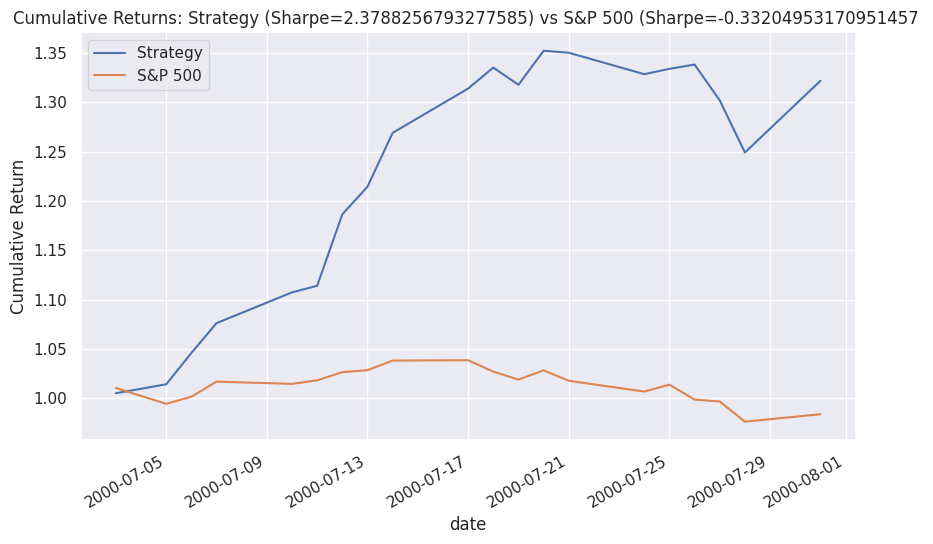

In [21]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

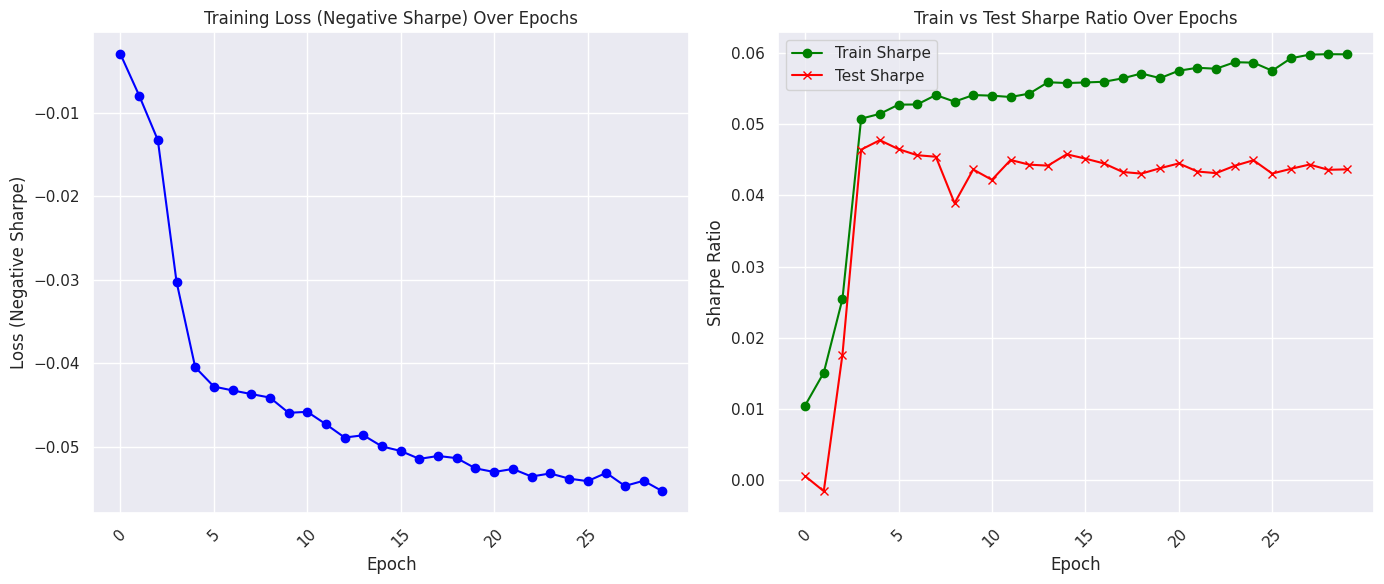

In [22]:
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

# Fourth run: include firm characteristics index

So far, we have been training the model using past returns. Let's see if including firm characteristics adds any information. 